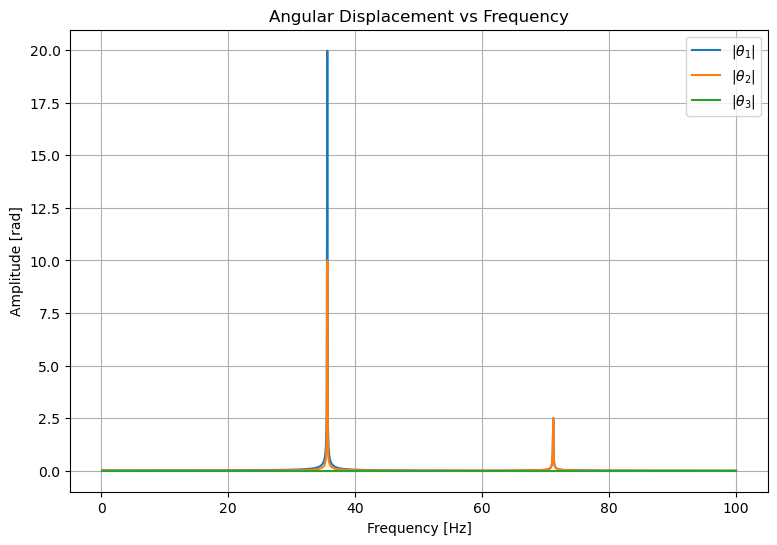

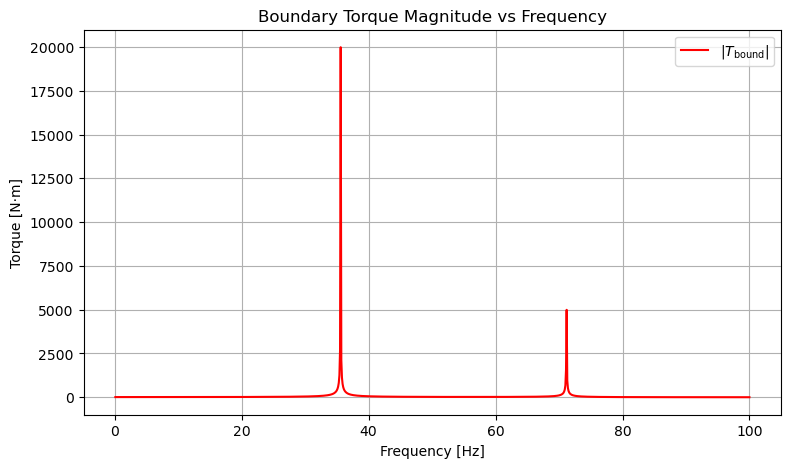

Done. You now have the forced-response angles and boundary torque.
For example, at the first frequency:
  Theta1 = (0.015000108566486137+0j) rad
  Theta2 = (0.005000049348431127+0j) rad
  Theta3 = 0j rad (should be ~0)
  T_bound = (-10.000098696862254+0j) N*m


In [1]:
import numpy as np
import matplotlib.pyplot as plt

def build_stiffness_matrix(k1, k2):
    """
    Build the 3x3 stiffness matrix for the chain of 3 inertias with
    no direct ground connection:
    
        I1 <---k1---> I2 <---k2---> I3
    
    K =
       [ k1,    -k1,       0   ]
       [ -k1,  k1 + k2,   -k2  ]
       [  0,    -k2,      k2   ]
    """
    K = np.array([
        [ k1,    -k1,      0   ],
        [-k1,  k1+k2,    -k2  ],
        [  0,    -k2,      k2  ]
    ], dtype=float)
    return K


def build_inertia_matrix(I1, I2, I3):
    """
    Build the 3x3 diagonal inertia matrix:
    
    I =
       [ I1,   0,   0 ]
       [  0,  I2,   0 ]
       [  0,   0,  I3 ]
    """
    I = np.diag([I1, I2, I3])
    return I


def build_4x4_system(I, K, w, Text):
    """
    Construct the 4x4 linear system that enforces:
    
      1)  (-w^2 * I + K) * [theta1, theta2, theta3]^T
          - [ 0, 0, 1 ]^T * T_bound  =  [Text, 0, 0]^T
      
      2)  Constraint:  theta3 = 0
    
    Unknowns = [theta1, theta2, theta3, T_bound]^T
    
    The final system can be written in block form as:
    
        [  D(1,1)   D(1,2)   D(1,3)    0     ] [theta1  ]   [ Text ]
        [  D(2,1)   D(2,2)   D(2,3)    0     ] [theta2  ] = [   0   ]
        [  D(3,1)   D(3,2)   D(3,3)   -1     ] [theta3  ]   [   0   ]
        [    0        0       1       0     ] [T_bound ]   [   0   ]
    
    where D(i,j) = K(i,j) - w^2 * I(i,j).
    """
    # Dynamic-stiffness for the first 3 DOFs:
    # D = K - w^2 * I
    D = K - w**2 * I
    
    # We'll build a 4x4 matrix "A" and a 4-vector "b"
    A = np.zeros((4, 4), dtype=float)
    b = np.zeros(4, dtype=float)
    
    # Fill the top-left 3x3 block with D
    A[0:3, 0:3] = D
    
    # The torque on the last inertia is -T_bound (unknown),
    # so the 3rd row has a -1 in the T_bound column:
    A[2, 3] = -1.0
    
    # The 4th row enforces constraint: theta3 = 0
    # That means "1.0 * theta3 + 0.0 * T_bound = 0"
    A[3, 2] = 1.0
    # (everything else is 0 in that row)
    
    # Right-hand side vector:
    #  1) For the first inertia, we have external torque = Text
    #     so b(0) = Text.
    #  2) The second inertia has no external torque => b(1)=0
    #  3) The third inertia's torque is T_bound (but we moved it to LHS),
    #     so b(2)=0.
    #  4) The constraint row => b(3)=0
    b[0] = Text
    
    return A, b


def solve_forced_response(I, K, freqs, Text):
    """
    For each frequency in 'freqs', build the 4x4 system
    and solve for [theta1, theta2, theta3, T_bound].
    
    Returns:
      Theta_solutions: shape (3, len(freqs)) with the angles
      Tbound_array:    shape (len(freqs),) with the boundary torque
    """
    npts = len(freqs)
    Theta_solutions = np.zeros((3, npts), dtype=complex)
    Tbound_array    = np.zeros(npts,       dtype=complex)
    
    for i, f in enumerate(freqs):
        w = 2.0 * np.pi * f
        # Build the 4x4 linear system
        A, b = build_4x4_system(I, K, w, Text)
        # Solve
        x = np.linalg.solve(A, b)
        # x = [theta1, theta2, theta3, T_bound]
        Theta_solutions[:, i] = x[0:3]
        Tbound_array[i]       = x[3]
        
    return Theta_solutions, Tbound_array


def main():
    """
    Example main script:
      - 3 inertias, 2 springs (chain), no direct ground.
      - T_ext on the first inertia, T_bound on the last inertia,
        plus the constraint theta3=0.
      - Frequency sweep, plotting magnitude of DOF response and T_bound.
    """
    # --- System parameters ---
    I1, I2, I3 = 0.01, 0.02, 0.015    # inertias (kg*m^2)
    k1, k2     = 1000.0, 2000.0      # torsional stiffnesses (N*m/rad)
    
    # Build matrices
    I_mat = build_inertia_matrix(I1, I2, I3)
    K_mat = build_stiffness_matrix(k1, k2)
    
    # External torque amplitude (on inertia 1)
    Text = 10.0  # [N*m], just an example
    
    # Frequency array
    f_min, f_max = 0.1, 100.0
    npts = 1000
    freqs = np.linspace(f_min, f_max, npts)
    
    # Solve forced response for each frequency
    Theta_solutions, Tbound_array = solve_forced_response(I_mat, K_mat, freqs, Text)
    
    # Magnitudes:
    Theta_mag = np.abs(Theta_solutions)
    Tbound_mag = np.abs(Tbound_array)
    
    # --- Plot results ---
    plt.figure(figsize=(9, 6))
    plt.plot(freqs, Theta_mag[0, :], label=r'$|\theta_1|$')
    plt.plot(freqs, Theta_mag[1, :], label=r'$|\theta_2|$')
    plt.plot(freqs, Theta_mag[2, :], label=r'$|\theta_3|$')
    plt.title("Angular Displacement vs Frequency")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude [rad]")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(9, 5))
    plt.plot(freqs, Tbound_mag, 'r', label=r'$|T_{\mathrm{bound}}|$')
    plt.title("Boundary Torque Magnitude vs Frequency")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Torque [N·m]")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Note: you can also look at real/imag parts if you want a full FRF.
    # Or overlay phases, etc.
    
    print("Done. You now have the forced-response angles and boundary torque.")
    print("For example, at the first frequency:")
    print("  Theta1 =", Theta_solutions[0, 0], "rad")
    print("  Theta2 =", Theta_solutions[1, 0], "rad")
    print("  Theta3 =", Theta_solutions[2, 0], "rad (should be ~0)")
    print("  T_bound =", Tbound_array[0], "N*m")


if __name__ == "__main__":
    main()


# NxN - System

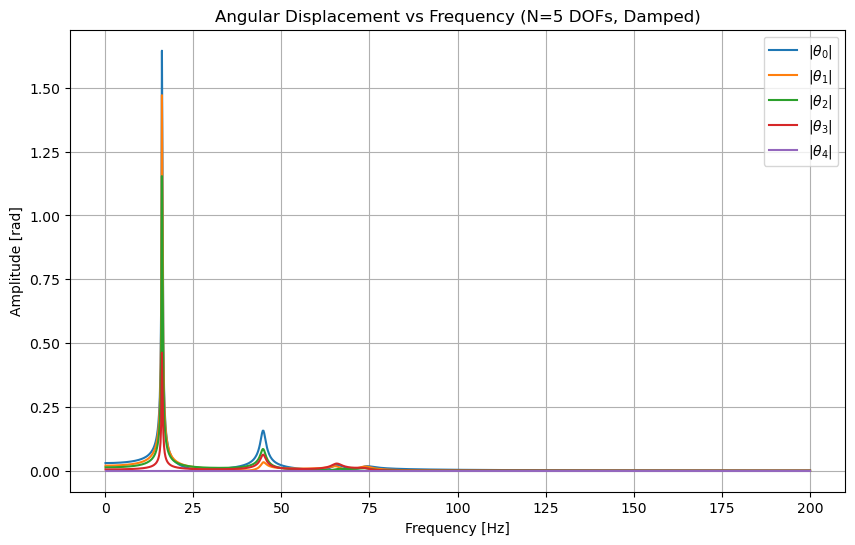

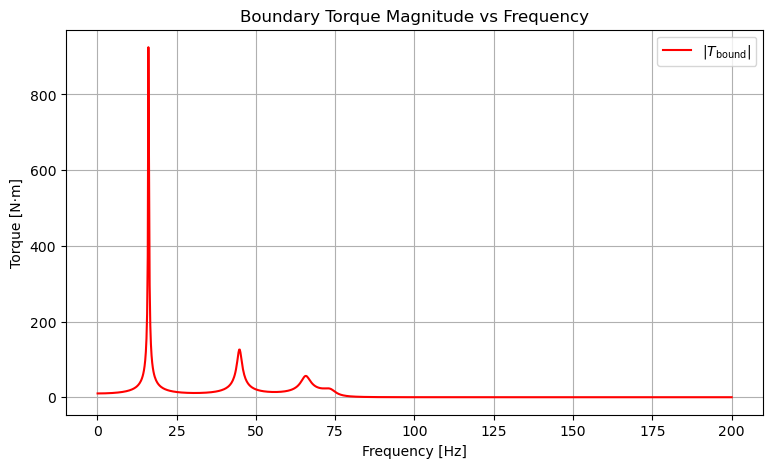

At f=10.0 Hz, last DOF (theta_4) = (6.065258812921367e-18+2.2608176509383475e-20j)
Boundary torque at that freq = (-17.53308690059714+0.08699149790943972j)

Done.


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def build_inertia_matrix(I_list):
    """
    Build an NxN diagonal inertia matrix from a 1D array-like of inertias.
    I_list[i] = inertia for DOF i.
    """
    return np.diag(I_list)

def build_chain_damping_matrix(c_list):
    """
    Build the NxN damping matrix for an N-inertia chain with no ground connection.
    c_list has length N-1, representing damping between:
      c_list[0] => DOF0 - DOF1
      c_list[1] => DOF1 - DOF2
      ...
      c_list[N-2] => DOF(N-2) - DOF(N-1)
    """
    N = len(c_list) + 1  # e.g. if c_list has length 4, we have 5 DOFs
    C = np.zeros((N, N), dtype=float)
    for i in range(N-1):
        c_ij = c_list[i]
        C[i, i]     += c_ij
        C[i, i+1]   -= c_ij
        C[i+1, i]   -= c_ij
        C[i+1, i+1] += c_ij
    return C

def build_chain_stiffness_matrix(k_list):
    """
    Build the NxN stiffness matrix for an N-inertia chain with no ground connection.
    k_list has length N-1, representing stiffness between adjacent DOFs:
      k_list[0] => DOF0 - DOF1
      k_list[1] => DOF1 - DOF2
      ...
      k_list[N-2] => DOF(N-2) - DOF(N-1)
    """
    N = len(k_list) + 1
    K = np.zeros((N, N), dtype=float)
    for i in range(N-1):
        k_ij = k_list[i]
        K[i, i]     += k_ij
        K[i, i+1]   -= k_ij
        K[i+1, i]   -= k_ij
        K[i+1, i+1] += k_ij
    return K


def build_system_matrix(I_mat, C_mat, K_mat, w):
    """
    Build D = (K + j*w*C - w^2 * I).
    This is the NxN "dynamic stiffness" for frequency w.
    """
    return K_mat + 1j*w*C_mat - (w**2)*I_mat


def build_Nplus1_system(D_mat, T_ext):
    """
    Given the NxN dynamic-stiffness matrix D_mat and
    the external torque vector T_ext (length N),
    build the (N+1)x(N+1) linear system that includes:
    
      D_mat * theta - e_{N-1} * T_bound = T_ext
      theta_{N-1} = 0   (constraint)
    
    Unknowns = [theta_0, theta_1, ..., theta_{N-1}, T_bound]^T  (size N+1).
    
    Returns (A, b):
      A => shape (N+1, N+1)
      b => shape (N+1,)
    
    The last row enforces theta_{N-1}=0.
    The second-to-last row (row N-1) includes a -1 for T_bound.
    """
    N = D_mat.shape[0]
    A = np.zeros((N+1, N+1), dtype=complex)
    b = np.zeros(N+1, dtype=complex)
    
    # Top-left NxN block => D_mat
    A[0:N, 0:N] = D_mat
    
    # The torque from T_bound only appears (negatively) in the last DOF's equation => row N-1
    # i.e. A[N-1, N] = -1
    A[N-1, N] = -1.0
    
    # Right-hand side for the top N rows => T_ext
    b[0:N] = T_ext
    
    # The last row enforces theta_{N-1} = 0
    # i.e. A[N, N-1] = 1
    # or any row shape that says "theta_{N-1}=0"
    A[N, N-1] = 1.0
    # b[N] = 0 by default
    
    return A, b


def solve_forced_response(I_mat, C_mat, K_mat, f_vals, T_ext):
    """
    For each frequency in f_vals, build the (N+1)x(N+1) system
    and solve for:
      x = [theta_0, ..., theta_{N-1}, T_bound].
    
    Returns:
      Theta_solutions => shape (N, len(f_vals)) for the DOF angles
      T_bound_array  => shape (len(f_vals),) for the boundary torque
    """
    N = I_mat.shape[0]
    npts = len(f_vals)
    Theta_solutions = np.zeros((N, npts), dtype=complex)
    T_bound_array  = np.zeros(npts, dtype=complex)
    
    for i, f in enumerate(f_vals):
        w = 2*np.pi*f
        # Build NxN dynamic stiffness
        D = build_system_matrix(I_mat, C_mat, K_mat, w)
        # Build (N+1)x(N+1) system
        A, b = build_Nplus1_system(D, T_ext)
        # Solve
        x = np.linalg.solve(A, b)
        # x[0..N-1] = the DOF angles
        # x[N]      = T_bound
        Theta_solutions[:, i] = x[0:N]
        T_bound_array[i]      = x[N]
    
    return Theta_solutions, T_bound_array


def main():
    """
    Example main to demonstrate:
      - N=5 inertias
      - 4 torsional damping/stiffness connections in a chain
      - No ground connection
      - Last DOF is constrained to zero => solve for boundary torque
      - Frequency sweep with damping
    """
    # ------------------------------
    # User-defined system parameters
    # ------------------------------
    # Number of DOFs
    N = 5
    # Inertias for each DOF
    I_list = np.array([0.01, 0.02, 0.03, 0.02, 0.01], dtype=float)
    # Damping between adjacent DOFs => length N-1=4
    c_list = np.array([0.1, 0.2, 0.1, 0.3], dtype=float)
    # Stiffness between adjacent DOFs => length N-1=4
    k_list = np.array([1000, 1500, 1200, 2000], dtype=float)
    
    # External torque vector T_ext (length N)
    # e.g. apply torque only at DOF0
    T_ext = np.zeros(N, dtype=complex)
    T_ext[0] = 10.0  # 10 N*m amplitude, for example
    
    # Frequency range
    f_min, f_max = 0.1, 200.0
    npts = 1000
    f_vals = np.linspace(f_min, f_max, npts)
    
    # ------------------------------
    # Build system matrices
    # ------------------------------
    I_mat = build_inertia_matrix(I_list)
    C_mat = build_chain_damping_matrix(c_list)
    K_mat = build_chain_stiffness_matrix(k_list)
    
    # ------------------------------
    # Solve forced response
    # ------------------------------
    Theta_solutions, T_bound_array = solve_forced_response(I_mat, C_mat, K_mat, f_vals, T_ext)
    
    # Magnitudes
    Theta_mag = np.abs(Theta_solutions)
    Tbound_mag = np.abs(T_bound_array)
    
    # ------------------------------
    # Plot results
    # ------------------------------
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(f_vals, Theta_mag[i, :], label=fr'$|\theta_{{{i}}}|$')
    plt.title("Angular Displacement vs Frequency (N=5 DOFs, Damped)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude [rad]")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(9, 5))
    plt.plot(f_vals, Tbound_mag, 'r', label=r'$|T_{\mathrm{bound}}|$')
    plt.title("Boundary Torque Magnitude vs Frequency")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Torque [N·m]")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # Example: check the last DOF is ~0 at a certain frequency
    f_check = 10.0
    idx_check = np.argmin(np.abs(f_vals - f_check))
    print(f"At f={f_check} Hz, last DOF (theta_{N-1}) = {Theta_solutions[N-1, idx_check]}")
    print(f"Boundary torque at that freq = {T_bound_array[idx_check]}")

    print("\nDone.")

if __name__ == "__main__":
    main()


# Harmonic excitation by engine order

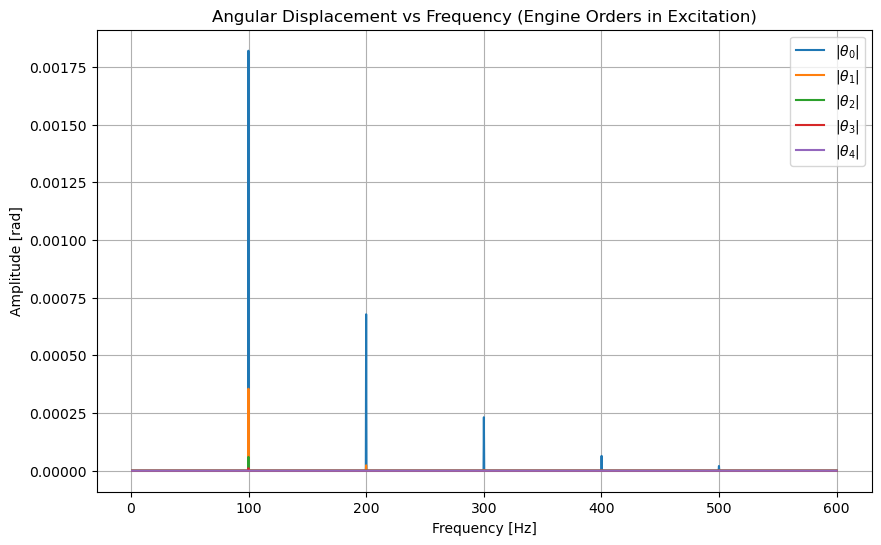

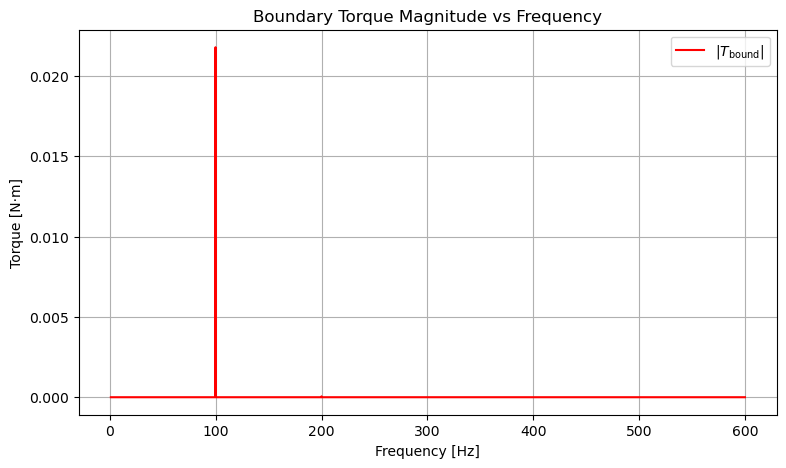

Engine order 0.5 => freq=100.0 Hz => index=330, amplitude placed=(5+0j) N·m
Engine order 1.0 => freq=200.0 Hz => index=664, amplitude placed=(10+0j) N·m
Engine order 1.5 => freq=300.0 Hz => index=998, amplitude placed=(8+0j) N·m
Engine order 2.0 => freq=400.0 Hz => index=1332, amplitude placed=(4+0j) N·m
Engine order 2.5 => freq=500.0 Hz => index=1665, amplitude placed=(2+0j) N·m

At f=300.05 Hz, the last DOF = (3.977012612152918e-29-4.129880929649779e-27j)
Boundary torque at that freq = (-9.11226539969334e-07-1.2085325167143426e-06j)

Done.


In [3]:
import numpy as np
import matplotlib.pyplot as plt

###############################################################################
# Build NxN system matrices
###############################################################################
def build_inertia_matrix(I_list):
    """
    Build an NxN diagonal inertia matrix from a 1D array-like of inertias.
    I_list[i] = inertia for DOF i.
    """
    return np.diag(I_list)

def build_chain_damping_matrix(c_list):
    """
    Build the NxN damping matrix for an N-inertia chain with NO ground connection.
    c_list has length (N-1), each c_list[i] is damping between DOF i and i+1.
    
    Returns an NxN matrix C:
      C[i,i]   += c_ij
      C[i,i+1] -= c_ij
      C[i+1,i] -= c_ij
      C[i+1,i+1] += c_ij
    """
    N = len(c_list) + 1
    C = np.zeros((N, N), dtype=float)
    for i in range(N-1):
        c_ij = c_list[i]
        C[i, i]     += c_ij
        C[i, i+1]   -= c_ij
        C[i+1, i]   -= c_ij
        C[i+1, i+1] += c_ij
    return C

def build_chain_stiffness_matrix(k_list):
    """
    Build the NxN stiffness matrix for an N-inertia chain with NO ground connection.
    k_list has length (N-1), each k_list[i] is stiffness between DOF i and i+1.
    
    Returns an NxN matrix K:
      K[i,i]   += k_ij
      K[i,i+1] -= k_ij
      K[i+1,i] -= k_ij
      K[i+1,i+1] += k_ij
    """
    N = len(k_list) + 1
    K = np.zeros((N, N), dtype=float)
    for i in range(N-1):
        k_ij = k_list[i]
        K[i, i]     += k_ij
        K[i, i+1]   -= k_ij
        K[i+1, i]   -= k_ij
        K[i+1, i+1] += k_ij
    return K

###############################################################################
# Build dynamic stiffness
###############################################################################
def build_dynamic_stiffness(I_mat, C_mat, K_mat, w):
    """
    For frequency w, build D = K + j*w*C - w^2 * I.
    Returns an NxN complex matrix.
    """
    return K_mat + 1j*w*C_mat - (w**2)*I_mat

###############################################################################
# Build the (N+1)x(N+1) system (include boundary torque + constraint)
###############################################################################
def build_Nplus1_system(D_mat, T_ext):
    """
    We have N DOFs. D_mat is NxN dynamic stiffness.
    T_ext is length N external torque vector at this freq.
    
    We add 1 unknown: T_bound (the torque on last DOF to enforce theta_{N-1} = 0).
    => x = [theta_0, ..., theta_{N-1}, T_bound]^T is length N+1.
    
    The top N equations: 
       D_mat * [theta_0..theta_{N-1}]^T  - e_{N-1} * T_bound = T_ext.
    The last equation: 
       theta_{N-1} = 0.
    
    Return (A, b) => shape (N+1,N+1), (N+1,).
    """
    N = D_mat.shape[0]
    A = np.zeros((N+1, N+1), dtype=complex)
    b = np.zeros(N+1, dtype=complex)
    
    # Top-left NxN block => D_mat
    A[0:N, 0:N] = D_mat
    # The boundary torque enters with -1 in row N-1 => that row of A is A[N-1, N] = -1
    A[N-1, N] = -1.0
    
    # RHS for top N eqns => T_ext
    b[0:N] = T_ext
    
    # Constraint: theta_{N-1} = 0 => row N => A[N, N-1] = 1
    A[N, N-1] = 1.0
    # b[N] = 0
    
    return A, b

###############################################################################
# Solve forced response for a "known T_ext at each frequency"
###############################################################################
def solve_forced_response_variable(I_mat, C_mat, K_mat, f_vals, T_ext_matrix):
    """
    We have an NxN system, plus boundary torque approach => total unknown size N+1.
    T_ext_matrix => shape (N, len(f_vals)), giving the external torque for each DOF
                    at each frequency index.
    
    We loop over all frequencies in f_vals, build A,b => solve for x => store results.
    
    Returns:
      Theta_solutions => shape (N, len(f_vals))
      T_bound_array   => shape (len(f_vals),)
    """
    N = I_mat.shape[0]
    npts = len(f_vals)
    Theta_solutions = np.zeros((N, npts), dtype=complex)
    T_bound_array   = np.zeros(npts,       dtype=complex)
    
    for i, f in enumerate(f_vals):
        w = 2*np.pi*f
        # NxN dynamic stiffness
        D = build_dynamic_stiffness(I_mat, C_mat, K_mat, w)
        
        # External torque vector for this freq
        T_ext = T_ext_matrix[:, i]
        
        # Build (N+1)x(N+1) system
        A, b = build_Nplus1_system(D, T_ext)
        
        # Solve
        x = np.linalg.solve(A, b)
        # x[0..N-1] = DOF angles, x[N] = T_bound
        Theta_solutions[:, i] = x[0:N]
        T_bound_array[i]      = x[N]
    
    return Theta_solutions, T_bound_array

###############################################################################
# Build engine-order forcing for a discrete frequency grid
###############################################################################
def build_engine_order_forcing(f_vals, engine_speed_rps, engine_orders, order_amps, N, dof_excited=0):
    """
    For a set of engine_orders (e.g. [0.5, 1.0, 1.5, ...]) and corresponding
    order_amps (same length),
    we place torque at the frequency bin i in f_vals that is closest to
    f_order = (engine_order) * engine_speed_rps.
    
    This returns T_ext_matrix (shape (N, len(f_vals))) where
      T_ext_matrix[dof_excited, i] = sum of amplitudes from any orders
                                     that "land" at freq f_vals[i].
      0 for other DOFs.
    
    In practice, you might refine or do interpolation if the orders don't align well.
    This discrete approach just picks the nearest bin.
    """
    npts = len(f_vals)
    T_ext_matrix = np.zeros((N, npts), dtype=complex)
    
    for order_i, amp_i in zip(engine_orders, order_amps):
        f_order = order_i * engine_speed_rps  # Hz
        if (f_order >= f_vals[0]) and (f_order <= f_vals[-1]):
            idx = np.argmin(np.abs(f_vals - f_order))
            # superimpose amplitude
            T_ext_matrix[dof_excited, idx] += amp_i
    
    return T_ext_matrix

###############################################################################
# Main demonstration
###############################################################################
def main():
    """
    Example:
      - N=5 inertias, chain of 4 dampers & springs (no ground).
      - Last DOF forced to zero => unknown boundary torque is solved.
      - Engine-order forcing:
         engine_orders = [0.5, 1.0, 1.5, 2.0, 2.5]
         order_amps    = [  5,   10,   8,   4,   2  ] (N*m)
         engine_speed_rps = 12000 rpm / 60 => 200 rev/s
        so the frequencies are [100, 200, 300, 400, 500] Hz
        each amplitude lumps into the nearest index in f_vals.
      - We'll do a wide sweep from 1 to 600 Hz, for instance.
    """
    # ------------------------------
    # System setup
    # ------------------------------
    N = 5
    # Inertias
    I_list = np.array([0.01, 0.02, 0.03, 0.025, 0.015])
    # Damping between DOFs => length 4
    c_list = np.array([0.1, 0.2, 0.15, 0.25])
    # Stiffness between DOFs => length 4
    k_list = np.array([1000, 1500, 1200, 2000])
    
    # Build NxN matrices
    I_mat = build_inertia_matrix(I_list)
    C_mat = build_chain_damping_matrix(c_list)
    K_mat = build_chain_stiffness_matrix(k_list)
    
    # Frequency range
    f_min, f_max = 1.0, 600.0
    npts = 2000
    f_vals = np.linspace(f_min, f_max, npts)
    
    # ------------------------------
    # Engine-order forcing
    # ------------------------------
    engine_orders = np.array([0.5, 1.0, 1.5, 2.0, 2.5])
    order_amps    = np.array([  5,   10,   8,   4,   2 ])  # N*m torque
    engine_speed_rpm = 12000.0
    engine_speed_rps = engine_speed_rpm / 60.0  # => 200 rev/s
    
    # Build T_ext_matrix => shape (N, len(f_vals))
    # We'll assume all torque is placed on DOF0:
    T_ext_matrix = build_engine_order_forcing(
        f_vals, engine_speed_rps, engine_orders, order_amps, N, dof_excited=0
    )
    
    # ------------------------------
    # Solve forced response
    # ------------------------------
    Theta_solutions, T_bound_array = solve_forced_response_variable(
        I_mat, C_mat, K_mat, f_vals, T_ext_matrix
    )
    # Magnitudes
    Theta_mag   = np.abs(Theta_solutions)
    Tbound_mag  = np.abs(T_bound_array)
    
    # ------------------------------
    # Plot results
    # ------------------------------
    plt.figure(figsize=(10, 6))
    for i in range(N):
        plt.plot(f_vals, Theta_mag[i, :], label=fr'$|\theta_{i}|$')
    plt.title("Angular Displacement vs Frequency (Engine Orders in Excitation)")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Amplitude [rad]")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(9, 5))
    plt.plot(f_vals, Tbound_mag, 'r', label=r'$|T_{\mathrm{bound}}|$')
    plt.title("Boundary Torque Magnitude vs Frequency")
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Torque [N·m]")
    plt.grid(True)
    plt.legend()
    plt.show()
    
    # (Optional) You can also see how the final T_ext_matrix looks.
    # For example, check indices for the engine-order frequencies:
    for order_i, amp_i in zip(engine_orders, order_amps):
        f_order = order_i * engine_speed_rps
        idx = np.argmin(np.abs(f_vals - f_order))
        print(f"Engine order {order_i} => freq={f_order:.1f} Hz => index={idx}, amplitude placed={T_ext_matrix[0, idx]} N·m")
    
    # Double-check last DOF is near zero for some sample frequency
    f_check = 300.0  # e.g. near the 1.5 order
    idx_check = np.argmin(np.abs(f_vals - f_check))
    print(f"\nAt f={f_vals[idx_check]:.2f} Hz, the last DOF = {Theta_solutions[N-1, idx_check]}")
    print(f"Boundary torque at that freq = {T_bound_array[idx_check]}")
    
    print("\nDone.")


if __name__ == "__main__":
    main()
